# <CENTER> PROJECT 2

# <CENTER> Customer segmentation using RFM Analysis

In [1]:
# import all the necessary modules

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

from scipy import stats

# Suppress all warnings
warnings.filterwarnings("ignore")

### <center> Data Preprocessing and Cleaning

Load the data and store it in the dataframe

In [2]:
sales=pd.read_csv('project2_data.csv', encoding="ISO-8859-1")
df = sales.copy()
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom  
...                 ...        ...         ...             ...  
541904  12/9/2011 12:50       0.85     12680.0          France  
541905  12/9/2011 12:50       2.10     12680.0          France  
541906  12/9/2011 12:50       4.15     12680.0          France  
541907  12/9/2011 12:50       4.15     12680.0          France  
541908  12/9/2011 12:50       4.95     12680.0          France  

[541909 rows x 8 columns]

In [3]:
print("No of Rows:", df.shape[0])
print("No of Columns:", df.shape[1])

No of Rows: 541909
No of Columns: 8


Description of Attributes

* **InvoiceNo**: Invoice number is a 6-digit integral number uniquely assigned to each transaction.

* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* **Description**: Product (item) name. Nominal.

* **Quantity**: The quantities of each product (item) per transaction. Numeric.

* **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.

* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

* **Country**: Country name. Nominal, the name of the country where each customer resides.

Check for the missing values and handle them accordingly

In [4]:
print("Check for null values")
df.isnull().sum()

Check for null values


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Here, there are missing values in Customer ID and Description. So its better to remove that as it's difficult to replace with out assumptions.

In [5]:
df.dropna(subset=['CustomerID','Description'],inplace = True)
print("After handling missing values")
df.isnull().sum()

After handling missing values


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Check for the types for all the attributes and convert it to the proper format

In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('int')

Looking at the data, we can see that there are some negative and zero numbers for quantity and unit pricing. As a result, we must disregard it in our analysis.

In [8]:
print("Inconsistencies in Quantity (ie. <=0 )", (df["Quantity"]<=0).sum())
print("Inconsistencies in Unit Price (ie. <=0 )", (df["UnitPrice"]<=0).sum())

Inconsistencies in Quantity (ie. <=0 ) 8905
Inconsistencies in Unit Price (ie. <=0 ) 40


There are stockcodes which contains 'C' which states that the order is cancelled/returned.

In [9]:
cancelled_items = df[df['InvoiceNo'].str.contains('C', flags=re.IGNORECASE, regex=True)]
df = df[~df['InvoiceNo'].str.contains('C', flags = re.IGNORECASE, regex = True)]
df = df[(df["Quantity"]>0) & (df["UnitPrice"]>0)]

There are some datas with the countries as 'Unspecified'. It's not needed for our analysis

In [10]:
df= df[df['Country']!='Unspecified']

Check for the duplicate rows in the data and drop it

In [11]:
print("Duplicated Rows =", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Duplicated Rows = 5189


There are some inconsistencies with the Desciption as there are more than one description for one particular stock code. So we need to check the size and handle that appropriately

In [12]:
print("Count of Unique Description =",df['Description'].value_counts().size)
print("Count of Unique StockCode =",df['StockCode'].value_counts().size)

Count of Unique Description = 3877
Count of Unique StockCode = 3665


Assume each stockcode has a single description. This discrepancy is created by multiple ways of writing the same description. So, for multiple descriptions, I'm going with the first occurrence.

In [13]:
first_description = df.groupby('StockCode')['Description'].first().to_dict()
first_stockcode = df.groupby('Description')['StockCode'].first().to_dict()

df['Description'] = df['StockCode'].map(first_description)
df['StockCode'] = df['Description'].map(first_stockcode)

print("Count of Unique Description =",df['Description'].value_counts().size)
print("Count of Unique StockCode =",df['StockCode'].value_counts().size)

Count of Unique Description = 3647
Count of Unique StockCode = 3647


Now all the stock code and descriptions have one to one relation

Check for the outliers and remove it if its necessary

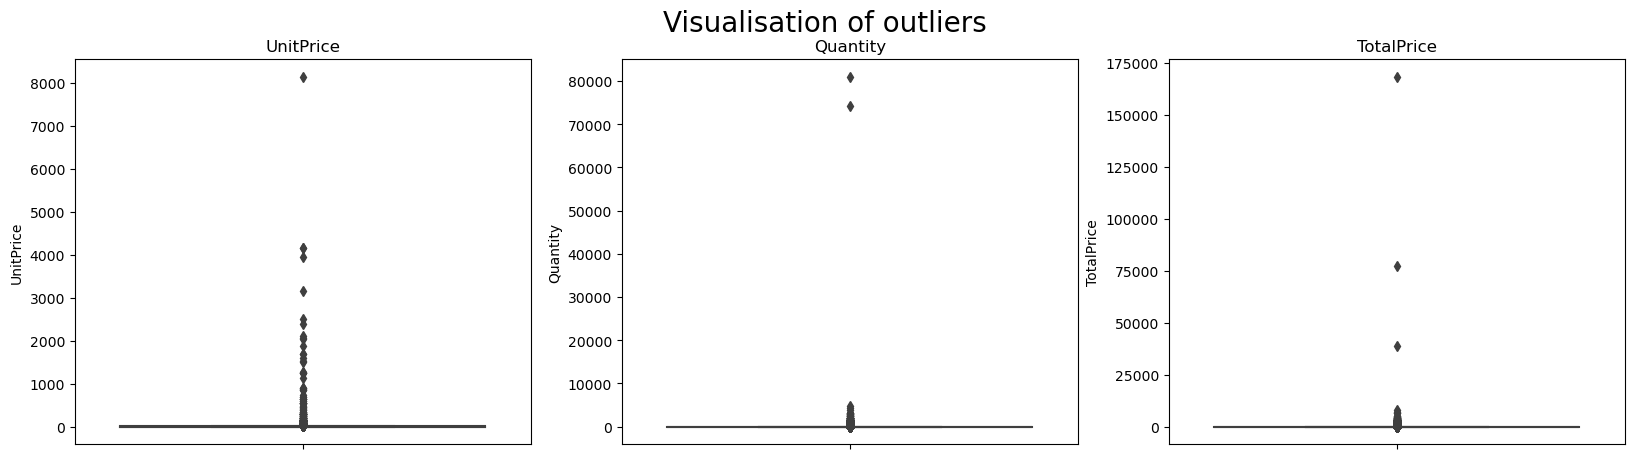

In [14]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Visualisation of outliers", size=20)

sns.boxplot(ax=axes[0], data=df, y="UnitPrice")
axes[0].set_title("UnitPrice")

sns.boxplot(ax=axes[1], data=df, y="Quantity")
axes[1].set_title("Quantity")

sns.boxplot(ax=axes[2], data=df, y="TotalPrice")
axes[2].set_title("TotalPrice")

plt.show()

Remove the outliers using the ZScore value as 3.

In [15]:
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]

Here is the cleaned Data

In [16]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
...                    ...        ...         ...             ...         ...  
541904 2011-12-09 12:50:00       0.85       12680          France       10.20  
541905 2011-12-09 12:50:00       2.10       12680          France       12.60  
541906 2011-12-09 12:50:00       4.15       12680          France       16.60  
541907 2011-12-09 12:50:00       4.15       12680          France       16.60  
541908 2011-12-09 12:50:00       4.95       12680          France       14.85  

[392109 rows x 9 columns]

### <center> RFM ANALYSIS

RFM segmentation is a marketing analysis approach that uses transactional behavior to identify and understand consumers. Recency, Frequency, and Monetary Value (RFM) are three fundamental factors used to assess client behavior:

Recency (R): This dimension indicates how recently a consumer purchased something. Customers who have made a recent purchase are frequently seen as more valued.

Frequency (F): This dimension measures how frequently a client purchases something. Customers who buy often tend to be more engaged and loyal.

Monetary Value (M): The overall monetary value of a customer's purchases is considered in this dimension. Customers who spend more money are frequently regarded as more valued.

RFM segmentation entails categorizing clients based on these three dimensions, yielding a matrix in which each customer is awarded a score for Recency, Frequency, and Monetary Value. These scores are then used to categorize customers. To separate clients into categories, segmentation can be done using quartiles or other approaches.

In [17]:
latest_timestamp = df['InvoiceDate'].max()
current_date = pd.to_datetime(latest_timestamp)
print(current_date)

2011-12-09 12:50:00


In [18]:
recency_df=df.groupby(["CustomerID"]).agg({"InvoiceDate":lambda x:((current_date-x.max()).days)})
recency_df

InvoiceDate
CustomerID             
12347                 1
12348                74
12349                18
12350               309
12352                35
...                 ...
18280               277
18281               180
18282                 7
18283                 3
18287                42

[4329 rows x 1 columns]

The recency analysis conducted on the provided dataset reveals valuable insights into customer purchasing behavior. The resulting DataFrame, 'recency_df,' succinctly captures the recency of each customer's last transaction, quantified in terms of the number of days since their latest purchase. For instance, customer 12347 made a purchase merely 1 day ago, indicating a high level of recent engagement, while customer 12350's recency value of 309 days suggests a longer gap between transactions. This information is crucial for understanding customer engagement patterns, tailoring marketing strategies, and identifying opportunities for targeted promotions or re-engagement efforts with customers who have been less active recently. The recency metric serves as a practical tool for customer segmentation and strategic decision-making in efforts to enhance overall customer satisfaction and maximize the effectiveness of marketing initiatives

In [19]:
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index(name="Frequency").set_index('CustomerID')
frequency_df

Frequency
CustomerID           
12347               7
12348               4
12349               1
12350               1
12352               8
...               ...
18280               1
18281               1
18282               2
18283              16
18287               3

[4329 rows x 1 columns]

The updated 'Frequency' analysis on the provided dataset, encapsulated in the DataFrame 'frequency_df,' illuminates distinct patterns of customer engagement. Each row signifies a unique customer, with the corresponding 'Frequency' column quantifying the number of their transactions. For example, customer 12347 exhibits a high frequency of 7, indicative of repeated interactions, while others like customer 12349 show a lower frequency of 1. This granularity in customer purchasing habits provides actionable insights for segmentation and targeted marketing efforts. Combined with the previously calculated recency metrics, this comprehensive view of customer behavior allows for the identification of various customer segments—ranging from highly engaged to less active. Such insights are invaluable for crafting personalized marketing strategies, optimizing customer retention initiatives, and ultimately enhancing the overall effectiveness of business decisions.

In [20]:
df2=df.copy()
df2["TotalPrice"]=df2["Quantity"]*df2["UnitPrice"]

moneytary_df=df2.groupby("CustomerID")["TotalPrice"].sum().reset_index(name="TotalExpense").set_index('CustomerID')
moneytary_df

TotalExpense
CustomerID              
12347            4310.00
12348            1797.24
12349            1757.55
12350             334.40
12352            2506.04
...                  ...
18280             180.60
18281              80.82
18282             178.05
18283            2045.53
18287            1837.28

[4329 rows x 1 columns]

The 'TotalExpense' analysis conducted on the dataset, as encapsulated in the 'moneytary_df' DataFrame, offers a comprehensive understanding of each customer's financial contribution to the business. With 'CustomerID' as the index and 'TotalExpense' as the corresponding column, the DataFrame reveals the cumulative monetary expenditure for each customer. For instance, customer 12347 exhibits a substantial 'TotalExpense' of 4310.00, highlighting their significant financial impact on the business. Integrating this monetary dimension with previously calculated recency and frequency metrics provides a nuanced perspective on customer value. Businesses can leverage this information to identify high-value customers, tailor marketing strategies to retain and nurture their loyalty, and allocate resources effectively. Such insights empower businesses to make informed decisions that prioritize customer relationships based on both transactional behavior and financial significance, ultimately contributing to long-term success and profitability.

Now combine all the Recency, Frequency and Monetary for the above dataframe to one dataframe

In [21]:
RFM=pd.concat([recency_df,frequency_df,moneytary_df],axis=1)
recency_df.columns=["Recency"]
frequency_df.columns=["Frequency"]
moneytary_df.columns=["Monetary"]
RFM.rename(columns={'InvoiceDate': 'Recency'}, inplace=True)
RFM

Recency  Frequency  TotalExpense
CustomerID                                  
12347             1          7       4310.00
12348            74          4       1797.24
12349            18          1       1757.55
12350           309          1        334.40
12352            35          8       2506.04
...             ...        ...           ...
18280           277          1        180.60
18281           180          1         80.82
18282             7          2        178.05
18283             3         16       2045.53
18287            42          3       1837.28

[4329 rows x 3 columns]

In [22]:
recency_quartiles = pd.qcut(RFM['Recency'], q=4, labels=[4, 3, 2, 1])
frequency_quartiles = pd.cut(RFM['Frequency'].rank(pct=True), bins=4, labels=[1, 2, 3, 4])
monetary_quartiles = pd.qcut(RFM['TotalExpense'], q=4, labels=[1, 2, 3, 4])
RFM['Recency_Quartile'] = recency_quartiles.astype(int)
RFM['Frequency_Quartile'] = frequency_quartiles.astype(int)
RFM['Monetary_Quartile'] = monetary_quartiles.astype(int)

# Calculate RFM score
RFM['RFM_Score'] = RFM['Recency_Quartile'] + RFM['Frequency_Quartile'] + RFM['Monetary_Quartile']
RFM

Recency  Frequency  TotalExpense  Recency_Quartile  \
CustomerID                                                       
12347             1          7       4310.00                 4   
12348            74          4       1797.24                 2   
12349            18          1       1757.55                 3   
12350           309          1        334.40                 1   
12352            35          8       2506.04                 3   
...             ...        ...           ...               ...   
18280           277          1        180.60                 1   
18281           180          1         80.82                 1   
18282             7          2        178.05                 4   
18283             3         16       2045.53                 4   
18287            42          3       1837.28                 3   

            Frequency_Quartile  Monetary_Quartile  RFM_Score  
CustomerID                                                    
12347                        4                  4         12  
12348                        3                  4          9  
12349                        1                  4          8  
12350                        1                  2          4  
12352                        4                  4         11  
...                        ...                ...        ...  
18280                        1                  1          3  
18281                        1                  1          3  
18282                        2                  1          7  
18283                        4                  4         12  
18287                        3                  4         10  

[4329 rows x 7 columns]

### <center> CUSTOMER SEGMENTATION USING K-MEANS

In [23]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)
scaled

array([[-9.05718854e-01,  3.58618362e-01,  3.61247566e-01, ...,
         1.46896551e+00,  1.34182679e+00,  1.61994365e+00],
       [-1.75561137e-01, -3.40447075e-02, -6.79088657e-03, ...,
         5.95695571e-01,  1.34182679e+00,  5.79221010e-01],
       [-7.35682126e-01, -4.26707777e-01, -1.26041939e-02, ...,
        -1.15084431e+00,  1.34182679e+00,  2.32313463e-01],
       ...,
       [-8.45705891e-01, -2.95820087e-01, -2.43950099e-01, ...,
        -2.77574367e-01, -1.34120701e+00, -1.14594085e-01],
       [-8.85714533e-01,  1.53660757e+00,  2.95756058e-02, ...,
         1.46896551e+00,  1.34182679e+00,  1.61994365e+00],
       [-4.95630274e-01, -1.64932397e-01, -9.26315478e-04, ...,
         5.95695571e-01,  1.34182679e+00,  9.26128557e-01]])

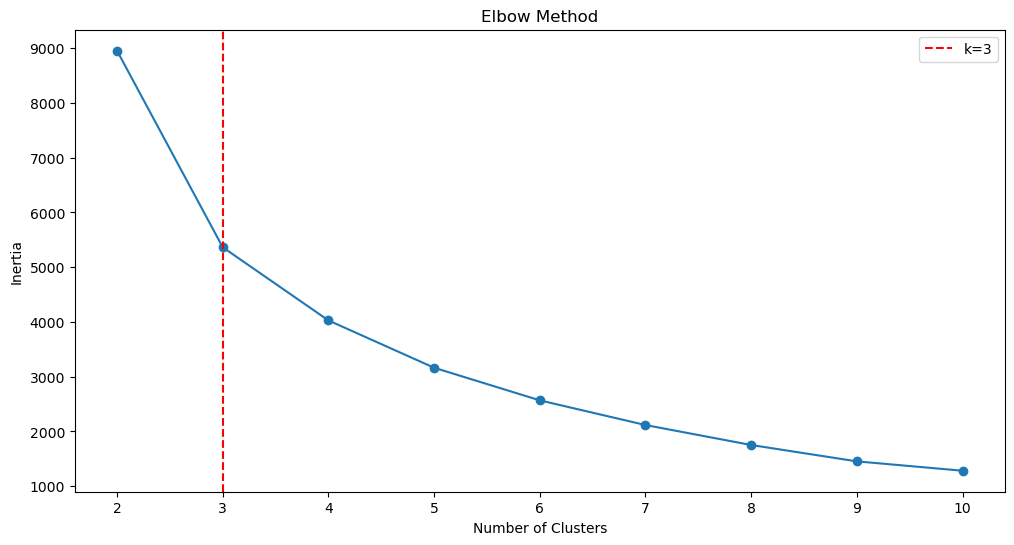

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

rfm_data = RFM[['Recency', 'Frequency', 'TotalExpense']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)
n_clusters_range = range(2, 11)
inertia_values = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia_values.append(kmeans.inertia_)
    
# Plot the elbow method
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Draw a dotted line for k=3 as a breaking point
plt.axvline(x=3, color='r', linestyle='--', label='k=3')
plt.legend()

plt.show()


From the elbow method we can see the feasible k value as 3

In [25]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame RFM with 'RFM_Score' column
X = RFM[['RFM_Score']]

# Choose the number of clusters (K)
k = 3


# Apply K-means algorithm
kmeans = KMeans(n_clusters=k, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(X)

# Analyze the results
cluster_means = RFM.groupby('Cluster')['RFM_Score'].mean()
print(cluster_means)

Cluster
0     4.516764
1    11.062342
2     8.008709
Name: RFM_Score, dtype: float64


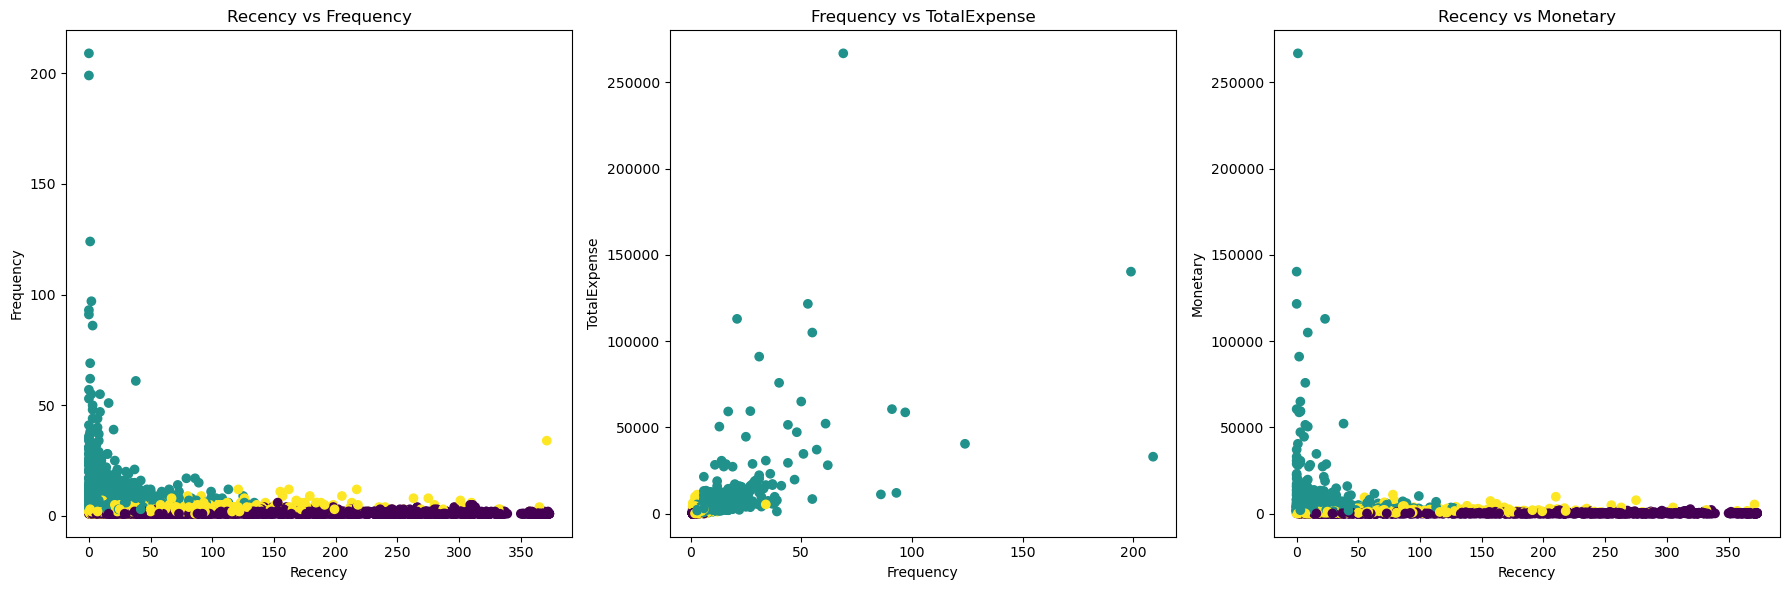

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot 1
axes[0].scatter(RFM['Recency'], RFM['Frequency'], c=RFM['Cluster'], cmap='viridis')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')

# Scatter plot 2
axes[1].scatter(RFM['Frequency'], RFM['TotalExpense'], c=RFM['Cluster'], cmap='viridis')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('TotalExpense')
axes[1].set_title('Frequency vs TotalExpense')

# Scatter plot 3
axes[2].scatter(RFM['Recency'], RFM['TotalExpense'], c=RFM['Cluster'], cmap='viridis')
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Recency vs Monetary')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

New customers have the lowest average order value. This may be because new customers are still learning about the business and its products or services.
Repeat customers have a higher average order value than new customers. This may be because repeat customers are more familiar with the business and its products or services, and they are more likely to make repeat purchases.
Loyal customers have the highest average order value. This may be because loyal customers are the most satisfied with the business and its products or services, and they are more likely to spend more money with the business

In [27]:
import plotly.express as px
# df = px.data.iris()
plotly_fig = px.scatter_3d(RFM, x = 'TotalExpense', y = 'Frequency', z = 'Recency', color = 'Cluster')
plotly_fig.show()

In [28]:
RFM

Recency  Frequency  TotalExpense  Recency_Quartile  \
CustomerID                                                       
12347             1          7       4310.00                 4   
12348            74          4       1797.24                 2   
12349            18          1       1757.55                 3   
12350           309          1        334.40                 1   
12352            35          8       2506.04                 3   
...             ...        ...           ...               ...   
18280           277          1        180.60                 1   
18281           180          1         80.82                 1   
18282             7          2        178.05                 4   
18283             3         16       2045.53                 4   
18287            42          3       1837.28                 3   

            Frequency_Quartile  Monetary_Quartile  RFM_Score  Cluster  
CustomerID                                                             
12347                        4                  4         12        1  
12348                        3                  4          9        2  
12349                        1                  4          8        2  
12350                        1                  2          4        0  
12352                        4                  4         11        1  
...                        ...                ...        ...      ...  
18280                        1                  1          3        0  
18281                        1                  1          3        0  
18282                        2                  1          7        2  
18283                        4                  4         12        1  
18287                        3                  4         10        1  

[4329 rows x 8 columns]

<img src ='https://www.slideteam.net/media/catalog/product/cache/1280x720/r/f/rfm_analysis_matrix_for_customer_segmentation_customer_segmentation_targeting_and_positioning_guide_slide01.jpg'>

In [29]:
# Mapping of segments according to recency and frequency scores of customers
seg_map = {
    r'1[1-2]': 'Lost',
    r'13': 'Hibernating',
    r'14': 'Can\'t Loose Them',
    r'2[1-2]': 'About to Sleep',
    r'23': 'Need Attention',
    r'[2-3][3-4]': 'Loyal Customers',
    r'31': 'Promising',
    r'[3-4]2': 'Recent Users',
    r'[3-4]3': 'Potential Loyalist',
    r'41': 'Price sensitive',
    r'44': 'Champions'
}

 Let's break down the explanations for each category:

1. **Lost:** Customers who were active but haven't made a recent purchase. These individuals might need targeted reactivation campaigns to bring them back to the business.

2. **Hibernating:** Customers who have been inactive for an extended period. It's crucial to re-engage these customers through personalized offers or promotions to revive their interest.

3. **Can't Lose Them:** Highly valuable and consistently active customers. It's essential to maintain the satisfaction of these customers and ensure they continue to receive personalized services to retain their loyalty.

4. **About to Sleep:** Customers showing signs of reduced engagement. Businesses should implement strategies to rekindle their interest, such as exclusive offers or loyalty programs.

5. **Need Attention:** Customers who have been inactive for a longer period and require special efforts to regain their attention. Targeted campaigns or incentives may be effective in reactivating them.

6. **Loyal Customers:** Consistently active and loyal customers. These individuals form a strong customer base and should be rewarded with loyalty programs, exclusive offers, or personalized services to maintain their loyalty.

7. **Promising:** Customers who recently started engaging. Businesses should nurture these relationships with targeted communication and incentives to encourage further engagement and potential loyalty.

8. **Recent Users:** Customers who recently began engaging but haven't yet reached a high level of loyalty. It's an opportunity to solidify the relationship with personalized experiences and promotions.

9. **Potential Loyalist:** Customers showing potential for long-term loyalty. Businesses should focus on building stronger connections through personalized interactions and incentives to foster loyalty.

10. **Price Sensitive:** Customers sensitive to pricing. Offering discounts, special promotions, or value-added services may be effective in retaining these customers.

11. **Champions:** Highly valuable and loyal customers consistently making significant purchases. These customers should be recognized and rewarded to maintain their loyalty and potentially increase their lifetime value.

These categories help businesses tailor their marketing strategies to different customer segments, addressing the unique needs and behaviors of each group.

In [30]:
# Recency and Frequency scores are turned into string format, combined and assigned to Segment
RFM['Segment'] = RFM['Recency_Quartile'].astype(str) + RFM['Frequency_Quartile'].astype(str)

# Segments are changed with the definitons of seg_map
RFM['Segment'] = RFM['Segment'].replace(seg_map, regex=True)
RFM

Recency  Frequency  TotalExpense  Recency_Quartile  \
CustomerID                                                       
12347             1          7       4310.00                 4   
12348            74          4       1797.24                 2   
12349            18          1       1757.55                 3   
12350           309          1        334.40                 1   
12352            35          8       2506.04                 3   
...             ...        ...           ...               ...   
18280           277          1        180.60                 1   
18281           180          1         80.82                 1   
18282             7          2        178.05                 4   
18283             3         16       2045.53                 4   
18287            42          3       1837.28                 3   

            Frequency_Quartile  Monetary_Quartile  RFM_Score  Cluster  \
CustomerID                                                              
12347                        4                  4         12        1   
12348                        3                  4          9        2   
12349                        1                  4          8        2   
12350                        1                  2          4        0   
12352                        4                  4         11        1   
...                        ...                ...        ...      ...   
18280                        1                  1          3        0   
18281                        1                  1          3        0   
18282                        2                  1          7        2   
18283                        4                  4         12        1   
18287                        3                  4         10        1   

                    Segment  
CustomerID                   
12347             Champions  
12348        Need Attention  
12349             Promising  
12350                  Lost  
12352       Loyal Customers  
...                     ...  
18280                  Lost  
18281                  Lost  
18282          Recent Users  
18283             Champions  
18287       Loyal Customers  

[4329 rows x 9 columns]

In [31]:
# Mean, median, count statistics of different segments
mn_ct = RFM[["Segment","Recency","Frequency", "TotalExpense"]].groupby("Segment").agg(["mean","median","count"])
mn_ct

Recency               Frequency               \
                          mean median count       mean median count   
Segment                                                               
About to Sleep       83.609984   77.0   641   1.355694    1.0   641   
Can't Loose Them    208.800000  184.5    20   9.000000    7.0    20   
Champions             6.504726    6.0   529  14.930057   10.0   529   
Hibernating         202.556522  190.0   115   3.452174    3.0   115   
Lost                251.976769  249.0   947   1.243928    1.0   947   
Loyal Customers      36.582723   30.0   683   6.291362    5.0   683   
Need Attention       84.474320   78.0   331   3.685801    4.0   331   
Potential Loyalist    8.012308    8.0   325   3.987692    4.0   325   
Price sensitive       9.291262   10.0   103   1.000000    1.0   103   
Promising            32.973684   32.0   266   1.000000    1.0   266   
Recent Users         21.474255   19.0   369   2.000000    2.0   369   

                   TotalExpense                  
                           mean    median count  
Segment                                          
About to Sleep       556.226382   383.750   641  
Can't Loose Them    2679.997000  1943.665    20  
Champions           7579.942722  3692.280   529  
Hibernating          962.171565   702.000   115  
Lost                 391.014109   291.050   947  
Loyal Customers     2642.125814  1680.720   683  
Need Attention      1402.156650  1149.020   331  
Potential Loyalist  1378.555477  1126.370   325  
Price sensitive      301.326699   243.550   103  
Promising            359.300038   266.945   266  
Recent Users         641.641382   511.350   369

The "Champions" stand out due to their extremely low recency of 6.5 days, high frequency (14.9), and significant total spending (7,580). 
Customers in the "Can't Lose Them" category, although being less frequent, sustain engagement with a short recency of 209 days and a high total expenditure (2,680). "Loyal Customers" demonstrate sustained commitment with a 36.6-day recency and a high total spend (2,642). "Recent Users" are a potential goldmine since they interacted within the last 21.5 days, making them prime for strategic conversion. With an 84.5-day recency, the "Need Attention" sector provides a possibility for reactivation with moderate frequency and expense (1,402). Customized strategy for each category can improve client interactions while driving corporate success.

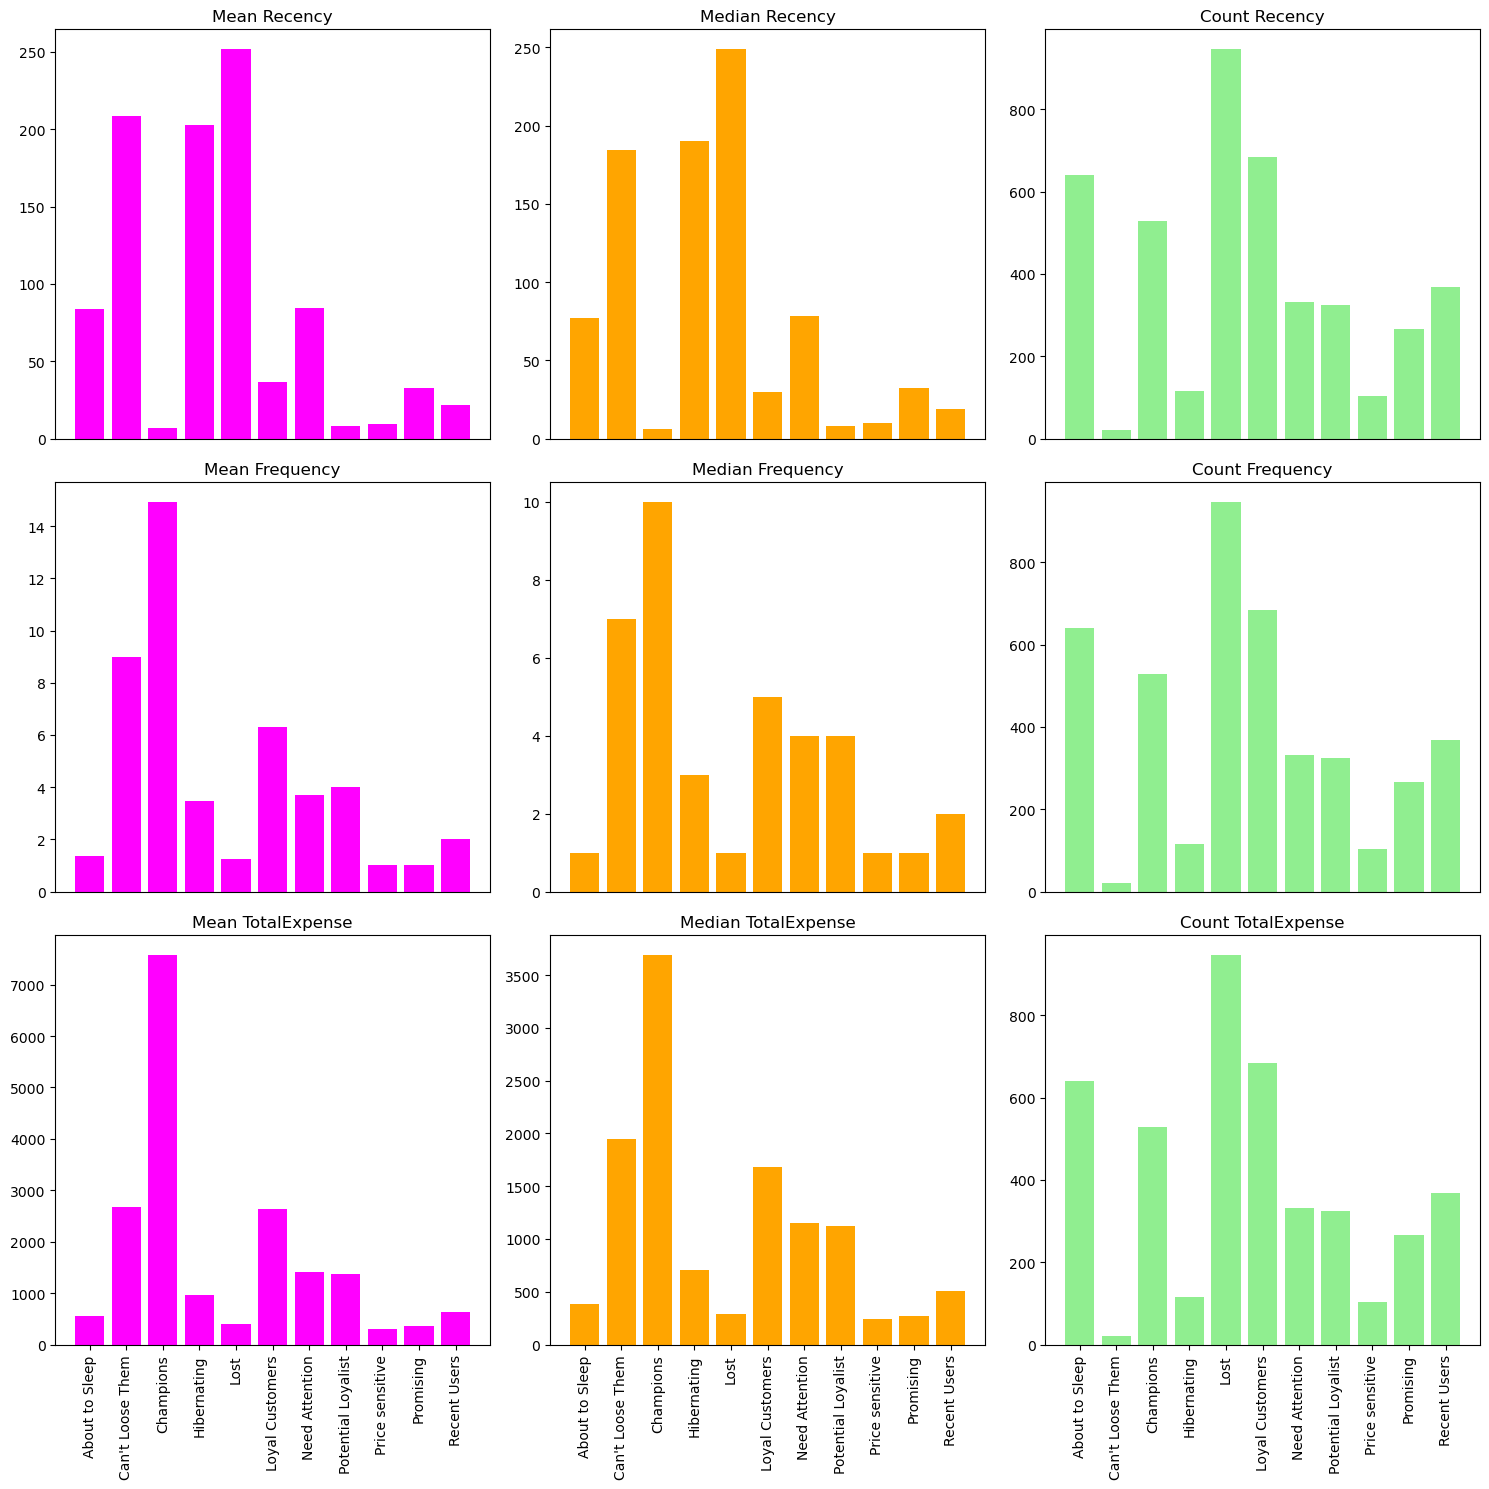

In [32]:
import matplotlib.pyplot as plt

# Assuming 'mn_ct' DataFrame is available

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plotting mean Recency
axes[0, 0].bar(mn_ct.index, mn_ct['Recency']['mean'], color='magenta')
axes[0, 0].set_title('Mean Recency')
axes[0, 0].get_xaxis().set_visible(False)

# Plotting median Recency
axes[0, 1].bar(mn_ct.index, mn_ct['Recency']['median'], color='orange')
axes[0, 1].set_title('Median Recency')
axes[0, 1].get_xaxis().set_visible(False)

# Plotting count Recency
axes[0, 2].bar(mn_ct.index, mn_ct['Recency']['count'], color='lightgreen')
axes[0, 2].set_title('Count Recency')
axes[0, 2].get_xaxis().set_visible(False)

# Plotting mean Frequency
axes[1, 0].bar(mn_ct.index, mn_ct['Frequency']['mean'], color='magenta')
axes[1, 0].set_title('Mean Frequency')
axes[1, 0].get_xaxis().set_visible(False)

# Plotting median Frequency
axes[1, 1].bar(mn_ct.index, mn_ct['Frequency']['median'], color='orange')
axes[1, 1].set_title('Median Frequency')
axes[1, 1].get_xaxis().set_visible(False)

# Plotting count Frequency
axes[1, 2].bar(mn_ct.index, mn_ct['Frequency']['count'], color='lightgreen')
axes[1, 2].set_title('Count Frequency')
axes[1, 2].get_xaxis().set_visible(False)

# Plotting mean TotalExpense
axes[2, 0].bar(mn_ct.index, mn_ct['TotalExpense']['mean'], color='magenta')
axes[2, 0].set_title('Mean TotalExpense')
axes[2, 0].tick_params(axis='x', rotation=90)

# Plotting median TotalExpense
axes[2, 1].bar(mn_ct.index, mn_ct['TotalExpense']['median'], color='orange')
axes[2, 1].set_title('Median TotalExpense')
axes[2, 1].tick_params(axis='x', rotation=90)

# Plotting count TotalExpense
axes[2, 2].bar(mn_ct.index, mn_ct['TotalExpense']['count'], color='lightgreen')
axes[2, 2].set_title('Count TotalExpense')
axes[2, 2].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


Customers who purchased "About to Sleep" products around 83 days ago represent a potential for re-engagement with targeted techniques. Despite a reduction in engagement, the brief recency period has the ability to rekindle their interest. "Potential Loyalists" on the other hand, show promise with a short recency of 8 days and a propensity to engage more regularly, showing their potential long-term worth to the organization. Customers that are "Price Sensitive" have a great sensitivity to pricing and make frequent purchases every 1 day on average. Their value-driven behavior is reflected in a total spend of $301, highlighting the significance of strategic pricing and value-based services.Similarly, "Promising" clients with a moderate recency of 32.97 days show higher engagement potential, making them a category worthwhile requiring deliberate nurturing. Finally, the "Lost" sector, which has been inactive for an average of 251.89 days, need focused reactivation efforts, as seen by their low frequency and lower average total cost.

<Figure size 1200x600 with 0 Axes>

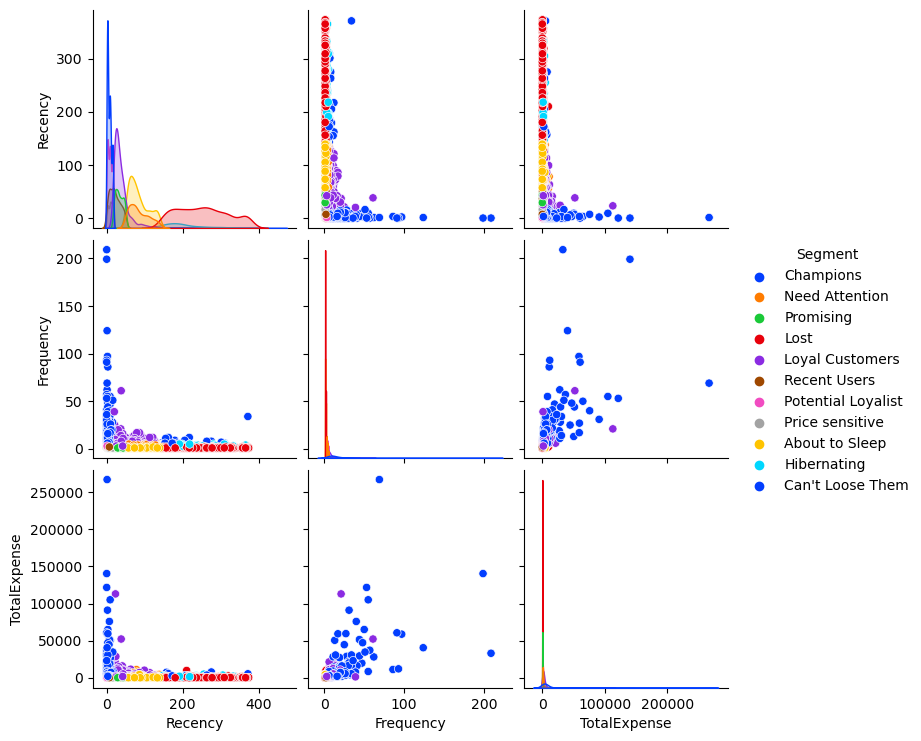

In [33]:
plt.figure(figsize=(12, 6))
# Extracting relevant columns
columns_to_plot = ['Recency', 'Frequency', 'TotalExpense', 'Segment']
data_for_pairplot = RFM[columns_to_plot]

# Plotting pair plot
sns.pairplot(data_for_pairplot, hue='Segment', palette='bright')
plt.show()

#### MARKETING RECOMMENDATIONS


Re-engage lost customers with targeted promotions, enticing recent purchases. Revive hibernating customers through personalized offers and time-limited promotions. Maintain loyalty for consistently active customers with exclusive incentives. Retain "About to Sleep" customers by implementing exclusive offers or loyalty programs. Reactivate longer inactive customers with strategic campaigns and tailored incentives. Reinforce loyalty for consistently engaged customers through rewards and exclusive offers. Nurture promising customers with personalized communication and special promotions. Solidify relationships with recent users through personalized experiences and incentives. Foster potential loyalists with stronger connections via personalized interactions. Retain price-sensitive customers with discounts and tailored cost-saving opportunities. Recognize and reward champions with exclusive perks to increase their lifetime value.

## <center> EXPLORATORY DATA ANALYSIS

## <CENTER>DATA OVERVIEW

In [34]:
print("No of Rows:", df.shape[0])
print("No of Columns:", df.shape[1])

No of Rows: 392109
No of Columns: 9


In [35]:
df.describe()

Quantity      UnitPrice     CustomerID     TotalPrice
count  392109.000000  392109.000000  392109.000000  392109.000000
mean       12.200929       2.994160   15287.936518      20.353941
std        34.147865       6.963158    1712.829038      42.362351
min         1.000000       0.001000   12347.000000       0.001000
25%         2.000000       1.250000   13956.000000       4.950000
50%         6.000000       1.950000   15150.000000      12.160000
75%        12.000000       3.750000   16791.000000      19.800000
max      3186.000000     908.160000   18287.000000     955.500000

In [36]:
import pandas as pd

earliest_timestamp = df['InvoiceDate'].min()
latest_timestamp = df['InvoiceDate'].max()

# Display the time period covered by the DataFrame
print("Time period covered in the DataFrame:")
print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)

Time period covered in the DataFrame:
Earliest Timestamp: 2010-12-01 08:26:00
Latest Timestamp: 2011-12-09 12:50:00


## <CENTER> CUSTOMER ANALYSIS

In [37]:
#a
df2=df.copy()
unique_row_df= df2.drop_duplicates(subset='CustomerID')["CustomerID"]
unique_row_df

0         17850
9         13047
26        12583
46        13748
65        15100
          ...  
536969    13436
537255    15520
538064    13298
538812    14569
541768    12713
Name: CustomerID, Length: 4329, dtype: int32

In [38]:
#b
df3=df.copy()

result= df3.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)
new_df = pd.DataFrame({'CustomerID': result.index, 'UniqueInvoiceCount': result.values})
new_df

CustomerID  UniqueInvoiceCount
0          12748                 209
1          14911                 199
2          17841                 124
3          13089                  97
4          14606                  93
...          ...                 ...
4324       15528                   1
4325       14569                   1
4326       16727                   1
4327       14566                   1
4328       15758                   1

[4329 rows x 2 columns]

In [39]:
#c
newdf2=new_df.head(5)
newdf2

CustomerID  UniqueInvoiceCount
0       12748                 209
1       14911                 199
2       17841                 124
3       13089                  97
4       14606                  93

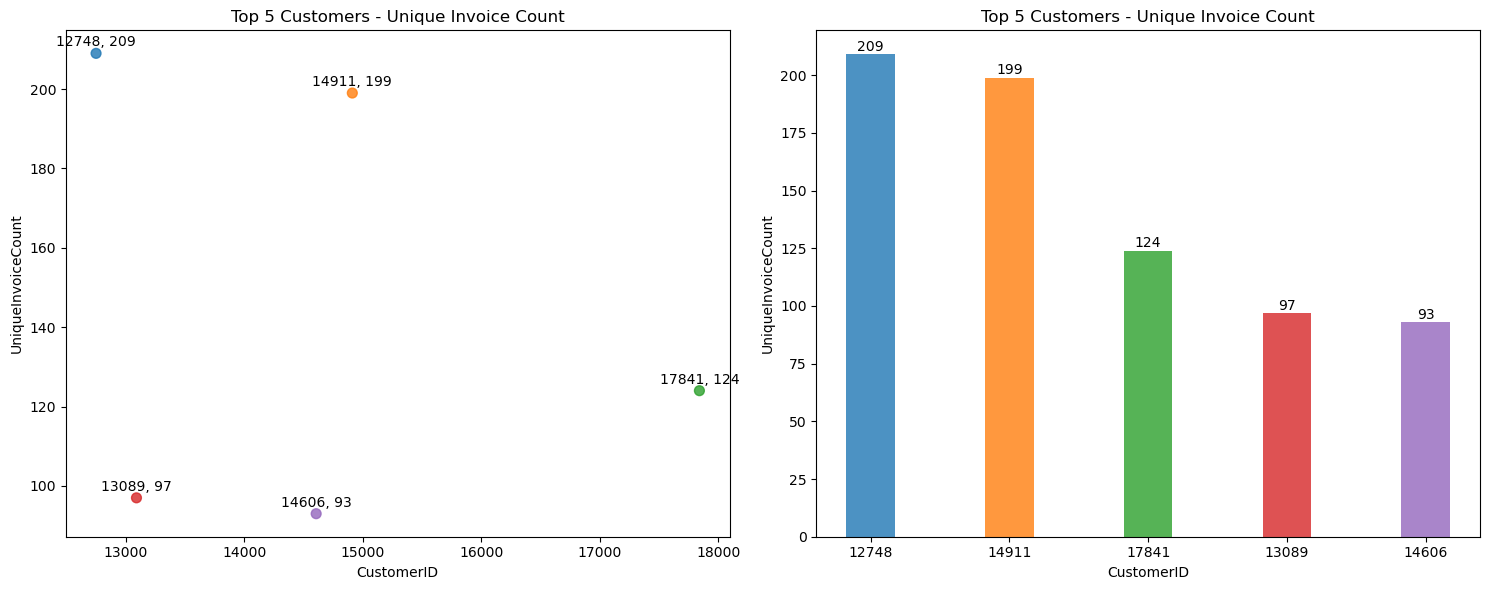

In [40]:
import matplotlib.pyplot as plt
import numpy as np

x = newdf2['CustomerID']
y_scatter = newdf2['UniqueInvoiceCount']
y_bar = newdf2['UniqueInvoiceCount']
bar_width = 0.35

bar_positions = np.arange(len(x))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a figure with one row and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
ax1.scatter(x, y_scatter, c=colors, s=50, alpha=0.8)
ax1.set_xlabel('CustomerID')
ax1.set_ylabel('UniqueInvoiceCount')
ax1.set_title('Top 5 Customers - Unique Invoice Count')

# Annotate each point with its x and y values
for i, txt in enumerate(zip(x, y_scatter)):
    ax1.annotate(f"{txt[0]}, {txt[1]}", (x.iloc[i], y_scatter.iloc[i]), textcoords="offset points", xytext=(0, 5), ha='center', color='black')

# Grouped bar chart
ax2.bar(bar_positions, y_bar, bar_width, color=colors, alpha=0.8)
ax2.set_xlabel('CustomerID')
ax2.set_ylabel('UniqueInvoiceCount')
ax2.set_title('Top 5 Customers - Unique Invoice Count')

# Annotate each bar with its height (UniqueInvoiceCount)
for i, yi in enumerate(y_bar):
    ax2.text(bar_positions[i], yi + 0.1, str(yi), ha='center', va='bottom', color='black')

# Set x-axis ticks and labels for the bar chart subplot
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(x)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()


The scatter plot illustrates the unique invoice counts for the top 5 customers. CustomerID 12748 stands out with the highest count of 209, suggesting a consistently high level of transactional activity and significant engagement with the business. CustomerID 14911 follows closely with 199 unique invoices, indicating another major contributor to the business. CustomerID 17841, 13089, and 14606 exhibit progressively lower unique invoice counts, suggesting varying levels of engagement. Analyzing these patterns provides insights into customer behavior and can guide strategic decisions, such as targeted marketing or customer retention efforts, to maximize business impact and enhance customer relationships

## <center> PRODUCT ANALYSIS

In [41]:
#Top 10 most frequently purchased products

product_freq = df.groupby('Description')['Quantity'].sum().reset_index()

# Sort the products by total sales in descending order
sorted_products = product_freq.sort_values(by='Quantity', ascending=False)

# Get the top 10 most frequently purchased products
top_10_purchased_products = sorted_products.head(10)
top_10_purchased_products

Description  Quantity
3565   WORLD WAR 2 GLIDERS ASSTD DESIGNS     49519
1669             JUMBO BAG RED RETROSPOT     42878
3095                SMALL POPCORN HOLDER     39468
2141     PACK OF 72 RETROSPOT CAKE CASES     33646
207        ASSORTED COLOUR BIRD ORNAMENT     30193
3480  WHITE HANGING HEART T-LIGHT HOLDER     28081
1932             MINI PAINT SET VINTAGE      26076
2108          PACK OF 12 LONDON TISSUES      25329
521                  BROCADE RING PURSE      22927
3342     VICTORIAN GLASS HANGING T-LIGHT     22404

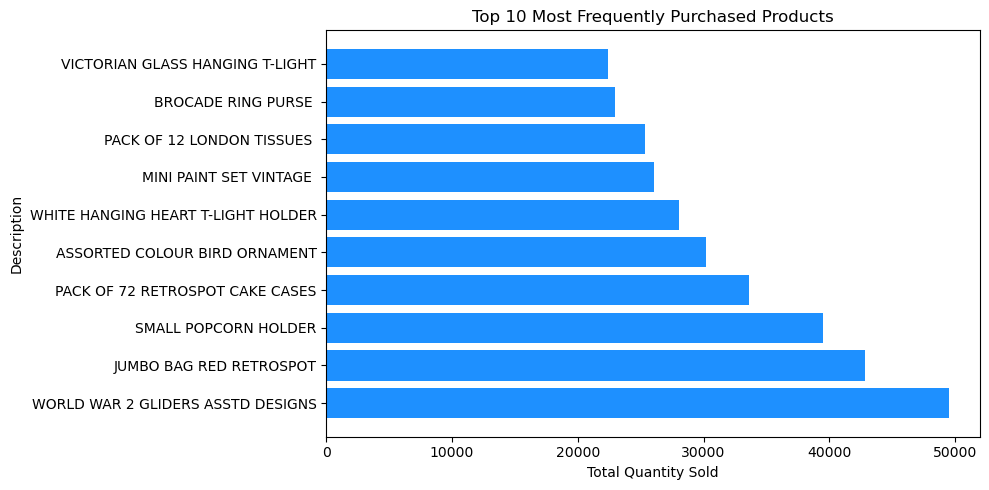

In [42]:
#Horizontal bar plot for top 10 most frequently purchased products
plt.figure(figsize=(10, 5))
plt.barh(top_10_purchased_products['Description'], top_10_purchased_products['Quantity'], color='dodgerblue')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Description')
plt.title('Top 10 Most Frequently Purchased Products')
#plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

Based on total sales quantity, the purpose of this report is to visually represent the top 10 most frequently purchased products. The top 10 products are shown in the horizontal bar plot below according to their total sales quantity. Every bar is a product, and the length of the bar indicates the total number of units sold. The bar graph shows the highest products purchased in an increasing manner. Based on this the “Paper Craft, Little Birdie” is the most frequently purchased product.

In [43]:
#Average price of product in the dataset
average_price = df.groupby('Description')['UnitPrice'].mean().reset_index()
average_price.sort_values(by = 'UnitPrice',ascending = False).head(10)

Description   UnitPrice
983                       DOTCOM POSTAGE  500.826667
2735  RUSTIC  SEVENTEEN DRAWER SIDEBOARD  158.076923
2622        REGENCY MIRROR WITH SHUTTERS  156.428571
3361        VINTAGE BLUE KITCHEN CABINET  146.750000
3407         VINTAGE RED KITCHEN CABINET  143.421053
665        CHEST NATURAL WOOD 20 DRAWERS  118.076923
1827       LOVE SEAT ANTIQUE WHITE METAL  114.024390
3403         VINTAGE POST OFFICE CABINET   66.360000
2768              SCHOOL DESK AND CHAIR    63.915385
897     DECORATIVE HANGING SHELVING UNIT   59.950000

In [44]:
average_price = df.groupby('Description')['UnitPrice'].mean().reset_index()
average_price.sort_values(by = 'UnitPrice',ascending = False).tail(10)

Description  UnitPrice
927   DISCO BALL CHRISTMAS DECORATION   0.118478
473    BLUE STONES ON WIRE FOR CANDLE   0.102941
3577                WRAP BAD HAIR DAY   0.100000
2261     PIECE OF CAMO STATIONERY SET   0.096774
2459   PORCELAIN BUDAH INCENSE HOLDER   0.095263
1798    LETTER SHAPE PENCIL SHARPENER   0.094634
1582     HOUSE SHAPE PENCIL SHARPENER   0.090851
610        CARTOON  PENCIL SHARPENERS   0.073200
2453       POPART WOODEN PENCILS ASST   0.043478
2146       PADS TO MATCH ALL CUSHIONS   0.001000

The table shows the top 10 and least 10 average price of products in the dataset. From the table we can infer that the top most average price of the product  is “Dotcom Postage” which has a value of around 744.1475 and the least average price of the product is “Pads To Match All Cushions” which has a value of around 0.0007. This table clearly gives an idea about the average price of products in the dataset.

In [45]:
#Product category that generates highest revenue
# Calculate the revenue for each row
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Group by product category and calculate the total revenue for each category
revenue = df.groupby('Description')['Revenue'].sum().reset_index()

# Find the category with the highest total revenue
highest_revenue = revenue.loc[revenue['Revenue'].idxmax()].head()

highest_revenue

Description    REGENCY CAKESTAND 3 TIER
Revenue                       122660.65
Name: 2620, dtype: object

In [46]:
top_ten_revenue = df.groupby('Description')['Revenue'].sum().reset_index()
top_ten_revenue = top_ten_revenue.sort_values(by = 'Revenue', ascending = False).head(10)
top_ten_revenue

Description    Revenue
2620            REGENCY CAKESTAND 3 TIER  122660.65
1669             JUMBO BAG RED RETROSPOT   79480.54
3480  WHITE HANGING HEART T-LIGHT HOLDER   76397.43
2464                             POSTAGE   69661.21
2208                       PARTY BUNTING   68785.23
207        ASSORTED COLOUR BIRD ORNAMENT   49056.25
693                        CHILLI LIGHTS   39890.71
2183     PAPER CHAIN KIT 50'S CHRISTMAS    38422.53
1662           JUMBO BAG DOILEY PATTERNS   37646.94
3146                      SPOTTY BUNTING   36144.25

In [47]:
top_revenue = top_ten_revenue.head(10)
top_revenue

Description    Revenue
2620            REGENCY CAKESTAND 3 TIER  122660.65
1669             JUMBO BAG RED RETROSPOT   79480.54
3480  WHITE HANGING HEART T-LIGHT HOLDER   76397.43
2464                             POSTAGE   69661.21
2208                       PARTY BUNTING   68785.23
207        ASSORTED COLOUR BIRD ORNAMENT   49056.25
693                        CHILLI LIGHTS   39890.71
2183     PAPER CHAIN KIT 50'S CHRISTMAS    38422.53
1662           JUMBO BAG DOILEY PATTERNS   37646.94
3146                      SPOTTY BUNTING   36144.25

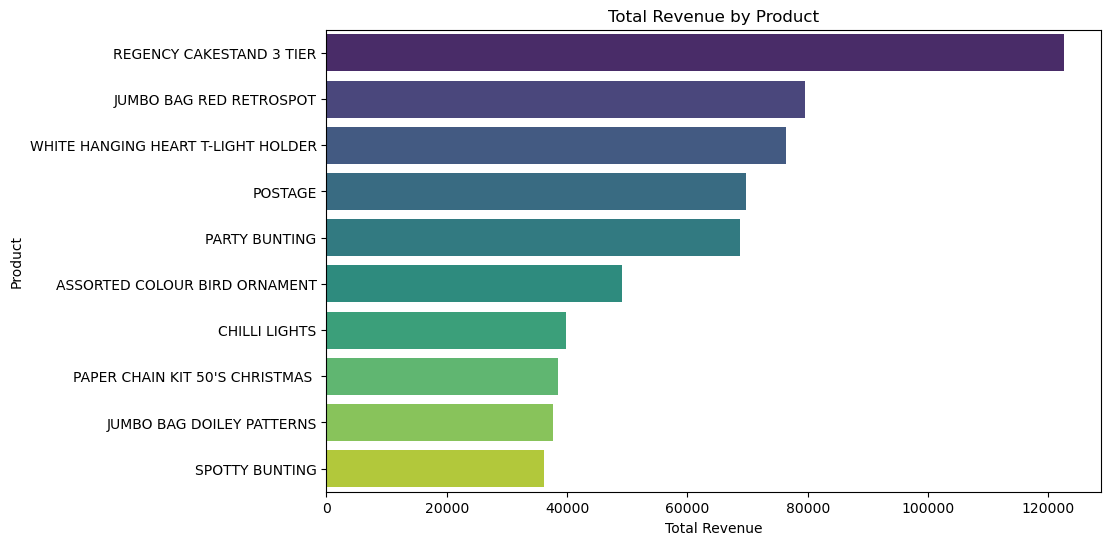

In [48]:
# Create a horizontal bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Revenue', y='Description', data=top_revenue, palette='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Product')
plt.title('Total Revenue by Product')
plt.show()

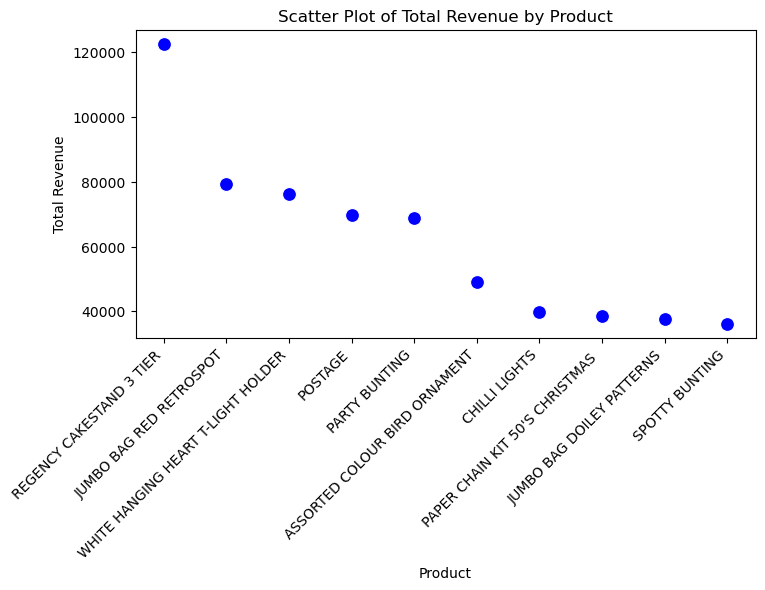

In [49]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Description', y='Revenue', data=top_ten_revenue, color='blue', s=100)
plt.xlabel('Product')
plt.ylabel('Total Revenue')
plt.title('Scatter Plot of Total Revenue by Product')
plt.xticks(rotation=45, ha='right')  
plt.show()

The above bar graph and scatter plot conveys about the total revenue generated by each product. This graphic helps with business planning by giving a brief but informative summary of the various products' respective revenue contributions. It also helps with decision-making. Both the plots give an inference about the top ten revenue generated by each product. The figure shows the revenue generated in a decreasing order. From the report we can infer that the highest revenue generated is “Paper Craft, Little Birdie”  which has a value above 160000.

## <CENTER> TIME ANALYSIS 

In [50]:
df_time_analysis=df.copy()

Most common day of the week for orders: Thursday
Most common hour of the day for orders: 12


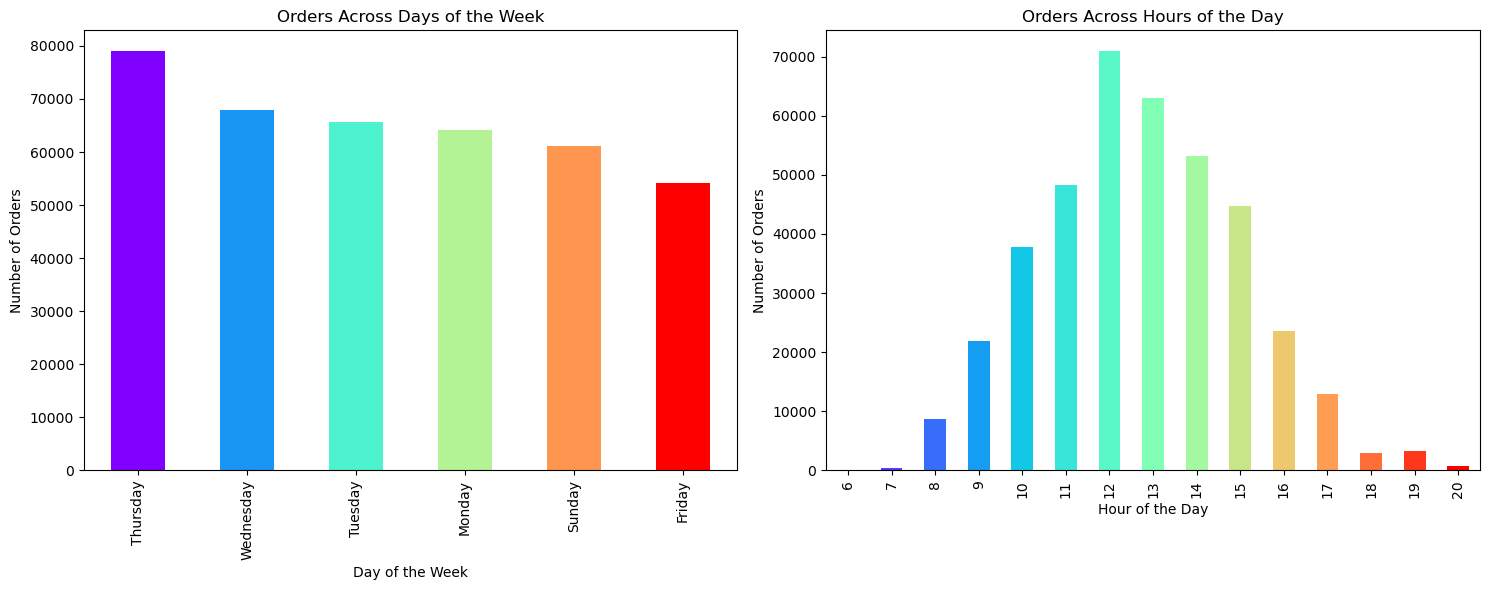

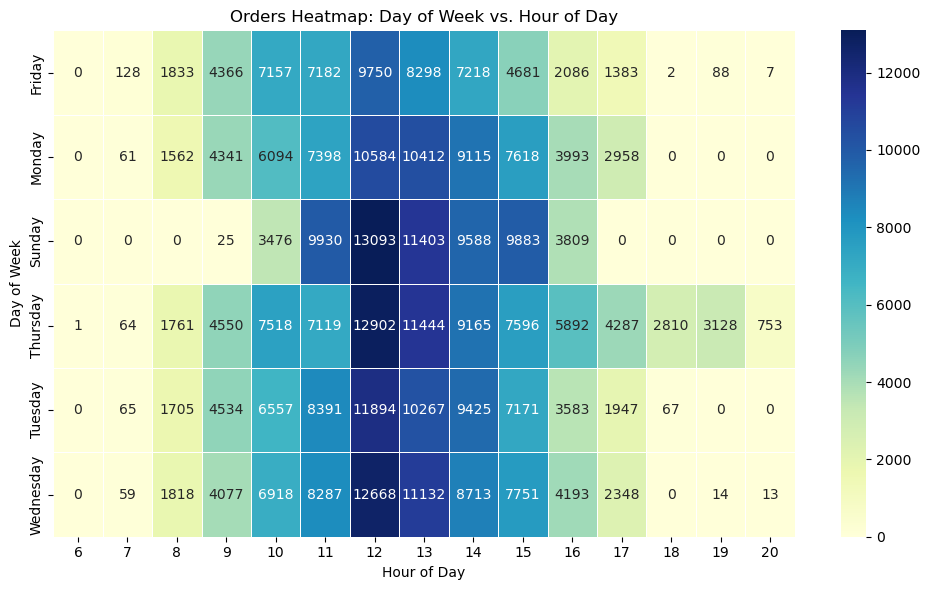

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_time_analysis['DayOfWeek'] = df_time_analysis['InvoiceDate'].dt.day_name()
df_time_analysis['HourOfDay'] = df_time_analysis['InvoiceDate'].dt.hour

# Calculate counts
day_of_week_counts = df_time_analysis['DayOfWeek'].value_counts()
hour_of_day_counts = df_time_analysis['HourOfDay'].value_counts()

# Print most common day and hour
print("Most common day of the week for orders:", day_of_week_counts.idxmax())
print("Most common hour of the day for orders:", hour_of_day_counts.idxmax())

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for day of the week
colors_day_of_week = plt.cm.rainbow(np.linspace(0, 1, len(day_of_week_counts)))
day_of_week_counts.plot(kind='bar', ax=axes[0], color=colors_day_of_week)
axes[0].set_title('Orders Across Days of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Orders')

# Plot for hour of the day
colors_hour_of_day = plt.cm.rainbow(np.linspace(0, 1, len(hour_of_day_counts)))
hour_of_day_counts.sort_index().plot(kind='bar', ax=axes[1], color=colors_hour_of_day)
axes[1].set_title('Orders Across Hours of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Orders')

plt.tight_layout()
plt.show()

# Create a separate figure for the heatmap
plt.figure(figsize=(10, 6))
heatmap_data = df_time_analysis.pivot_table(index='DayOfWeek', columns='HourOfDay', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d', linewidths=.5)
plt.title('Orders Heatmap: Day of Week vs. Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

plt.tight_layout()
plt.show()


Most Common Day of the Week: Thursday

The highest number of orders occurs on Thursdays. This could indicate that Thursdays are particularly popular for shopping or that there might be specific promotions or marketing strategies implemented on that day.
Most Common Hour of the Day: 12 (Noon)

The peak ordering hour is at noon. 

This could be associated with lunch breaks, where people might take the opportunity to browse and make purchases. Alternatively, it could be influenced by specific events, promotions, or activities happening around that time.

In [52]:
#b
df_time_analysis2 = df_time_analysis.sort_values(by=['CustomerID', 'InvoiceDate'])
df_time_analysis2
df_time_analysis2['PreviousInvoiceDate'] = df_time_analysis2.groupby('CustomerID')['InvoiceDate'].shift(1)
df_time_analysis2['ProcessingTime'] = (df_time_analysis2['InvoiceDate'] - df_time_analysis2['PreviousInvoiceDate']).dt.total_seconds() / 3600  # in hours
average_processing_time = df_time_analysis2['ProcessingTime'].mean()
print("The average processing time is :",round(average_processing_time) , "hours")

The average processing time is : 35 hours


Customer Purchase Patterns:

The average processing time of 35 hours suggests that, on average, customers make repeat purchases within a relatively short time frame. This could indicate that the products offered are frequently used or consumed, prompting customers to replenish their supplies quickly. Opportunities for Targeted Marketing:

With a relatively short average processing time, there may be opportunities for targeted marketing strategies. For example, sending personalized promotions or recommendations shortly after a customer's previous purchase could encourage them to make additional orders. Efficient Inventory Management:

Understanding the average time between consecutive orders helps in optimizing inventory management. Businesses can adjust stock levels and reorder points to align with the expected frequency of customer purchases


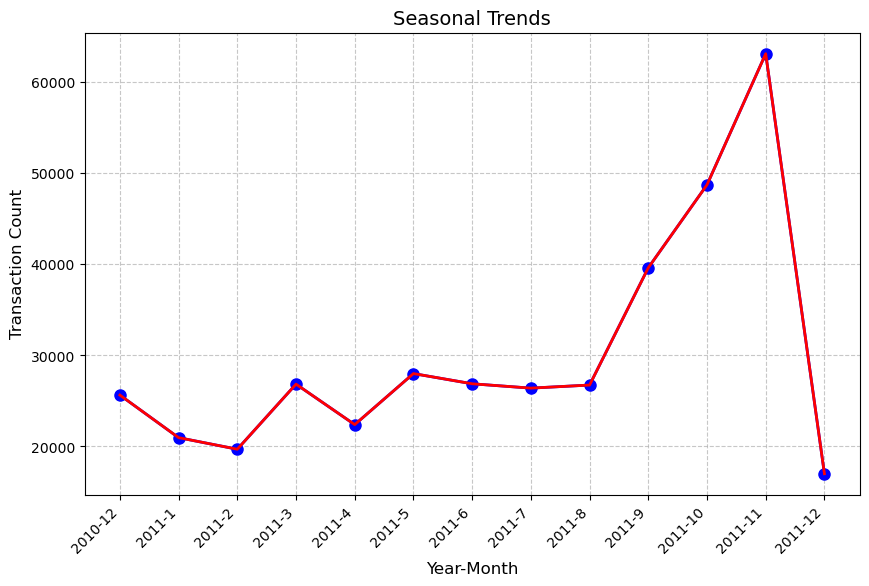

In [53]:
import matplotlib.pyplot as plt


df_time_analysis['InvoiceYear'] = df_time_analysis['InvoiceDate'].dt.year
df_time_analysis['InvoiceMonth'] = df_time_analysis['InvoiceDate'].dt.month
monthly_data = df_time_analysis.groupby(['InvoiceYear', 'InvoiceMonth']).size().reset_index(name='TransactionCount')

monthly_data['YearMonth'] = monthly_data['InvoiceYear'].astype(str) + '-' + monthly_data['InvoiceMonth'].astype(str)

plt.figure(figsize=(10, 6))  
plt.plot(monthly_data['YearMonth'], monthly_data['TransactionCount'], marker='o', color='blue', linestyle='-', linewidth=2, markersize=8, label='Transaction Count (Markers Blue, Line Red)')
plt.plot(monthly_data['YearMonth'], monthly_data['TransactionCount'], marker='o', color='red', linestyle='-', linewidth=2, markersize=0, label='_nolegend_')  # Line without markers

# Additional aesthetics
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.title('Seasonal Trends', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True) 


Yearly Shift in Transaction Volumes: The dataset highlights a significant shift in transaction counts from 2010 to 2011, indicating potential changes in customer behavior or business strategies. Analyzing the factors contributing to this transition can unveil key insights into the evolving dynamics of the business landscape during this period.

Identifying Seasonal Peaks: Specific months, notably November and October in 2011, showcase pronounced peaks in transaction volumes, suggesting strong seasonal influences. Understanding and leveraging these seasonal trends enables businesses to optimize resource allocation, inventory management, and marketing strategies to capitalize on peak

## <center> GEOGRAPHICAL ANALYSIS

Here we check the countries with highest number of orders

In [54]:
orders_per_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
orders_per_country = orders_per_country.reset_index(name='OrderCount')
print("Top 5 countries with the highest number of orders")
orders_per_country.head()

Top 5 countries with the highest number of orders


Country  OrderCount
0  United Kingdom       16581
1         Germany         457
2          France         386
3            EIRE         258
4         Belgium          98

Plot the values for the number of orders per country using the choropleth maps

In [55]:
import plotly.express as px

# Create a choropleth map using the country names provided to plot number of orders

fig = px.choropleth(
    orders_per_country,
    locations='Country',
    locationmode='country names',
    color='OrderCount',
    hover_name='Country',
    title='Number of Orders per Country',
    color_continuous_scale='Reds'
)

# Show the plot
fig.show()

The choropleth map generated using Plotly Express provides a visually intuitive representation of the distribution of order counts across different countries. The map vividly illustrates the disparities in order volumes, with varying shades of red indicating the magnitude of orders in each country. Unsurprisingly, the United Kingdom stands out prominently with a deep color, signifying a significantly higher number of orders compared to other countries. This spatial visualization offers a quick and insightful overview of the geographical distribution of business activity, aiding in identifying key markets and potential areas for strategic focus. The interactive nature of the choropleth map allows for a dynamic exploration of order counts across countries, enhancing the interpretability of the data

In [56]:
# Calculate the average order value for each country

avg_order = df.groupby(['Country', 'InvoiceNo'])['TotalPrice'].sum().reset_index(name='OrderTotal')
avg_order = avg_order.groupby('Country')['OrderTotal'].mean().reset_index(name='Avg Order Value')
avg_order.sort_values('Avg Order Value',ascending=False,inplace=True)
print("Top 5 countries with high average order values")
avg_order.head()


Top 5 countries with high average order values


Country  Avg Order Value
23  Netherlands      3023.668667
0     Australia      2219.270351
29    Singapore      1904.458000
19        Japan      1765.748125
20      Lebanon      1693.880000

Now plot the same choropleth map for the average order value per country

In [57]:
fig = px.choropleth(
    avg_order,
    locations='Country',
    locationmode='country names',
    color='Avg Order Value',
    hover_name='Country',
    title='Average Order Value per Country',
    color_continuous_scale='Reds'
)

# Show the plot
fig.show()

The choropleth map generated using Plotly Express effectively communicates the geographical distribution of average order values across different countries. The visualization vividly showcases variations in purchasing behavior, with countries shaded in different intensities of red, reflecting their respective average order values. The Netherlands emerges as the top performer, demonstrating the highest average order value, followed by Australia, Singapore, Japan, and Lebanon. This spatial analysis provides valuable insights into regions where customers tend to place higher-value orders, offering businesses strategic guidance for targeted marketing efforts and personalized customer engagement strategies. The interactive nature of the choropleth map enhances the interpretability of the data, allowing for a dynamic exploration of average order values on a global scale.

## <CENTER> PAYMENT ANALYSIS

Since there is no data available related to the payment method, we are adding a new column into the dataframe named PaymentMethod with random values

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

   Revenue PaymentMethod  
0    15.30    CreditCard  
1    20.34           EMI  
2    22.00           EMI  
3 

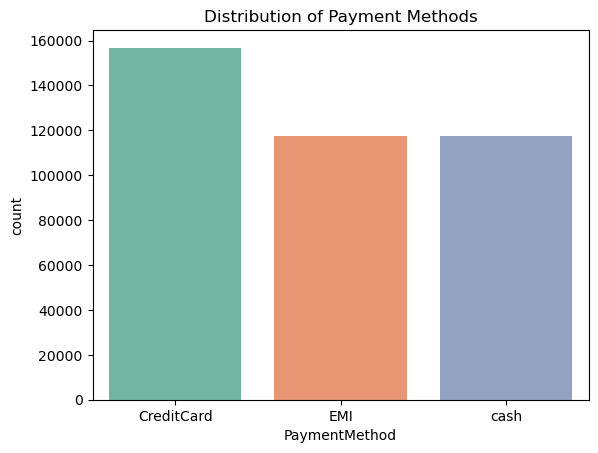

In [58]:
np.random.seed(42)
payment_methods = ['CreditCard', 'cash', 'EMI']
weights = [0.4, 0.3, 0.3]
df['PaymentMethod'] = np.random.choice(payment_methods, size=len(df), p=weights)

print(df.head())

payment_method_analysis = df.groupby('PaymentMethod')['TotalPrice'].describe()


print(payment_method_analysis)
color_palette="Set2"
sns.countplot(x='PaymentMethod', data=df,palette=color_palette)
plt.title('Distribution of Payment Methods')
plt.show()

Payment method used the most is credit card.The mean total price is slightly higher for EMI payments compared to credit card payments, while the standard deviation is similar for both methods. Cash payments tend to have a slightly lower median and standard deviation compared to credit card and EMI payments.

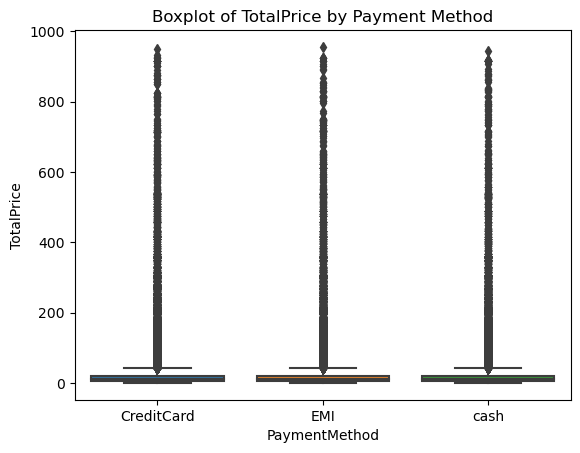

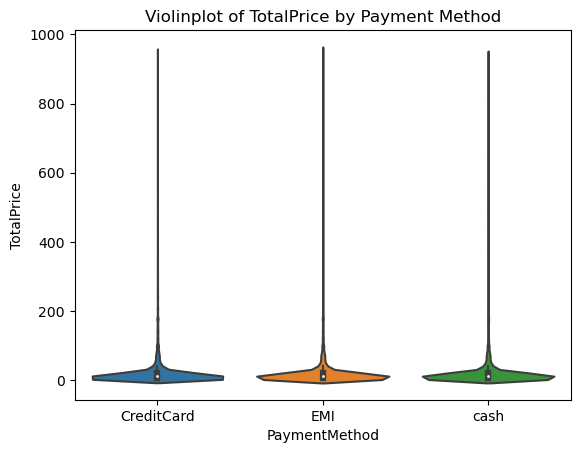

In [59]:
# Box plot of TotalPrice by PaymentMethod
sns.boxplot(x='PaymentMethod', y='TotalPrice', data=df)
plt.title('Boxplot of TotalPrice by Payment Method')
plt.show()

sns.violinplot(x='PaymentMethod', y='TotalPrice', data=df)
plt.title('Violinplot of TotalPrice by Payment Method')
plt.show()

The median of credit card payment method is high compared to that of the cash and EMI.
IQR range is more in Credit card and then cash and at last for the EMI.

This shows customers prefer using Credit card and Cash payment more than that of the EMI option available to them.

The total price for all three payment methods is relatively widely distributed. This means that there is a wide range of total prices for each payment method.

There is also a significant amount of outliners present in the graph which shows that payment made could have been higher than expected range during on seasonal sales.

## <CENTER> CUSTOMER BEHAVIOUR

In [60]:
# Calculate the first and last purchase dates for each customer
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min()
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()

duration = last_purchase - first_purchase


average_duration = duration.mean()

print("Average duration between first and last purchase of all customers =", average_duration)
duration = duration.reset_index().rename({'InvoiceDate':'Active duration'},axis=1)
print("\nThe Active Duration of each customer")
duration

Average duration between first and last purchase of all customers = 130 days 17:06:00.859320860

The Active Duration of each customer


CustomerID   Active duration
0          12347 365 days 00:55:00
1          12348 282 days 18:04:00
2          12349   0 days 00:00:00
3          12350   0 days 00:00:00
4          12352 260 days 02:04:00
...          ...               ...
4324       18280   0 days 00:00:00
4325       18281   0 days 00:00:00
4326       18282 118 days 22:08:00
4327       18283 333 days 21:48:00
4328       18287 158 days 22:50:00

[4329 rows x 2 columns]

Now segment the above customers based on the KMeans clustering based on their active duration.

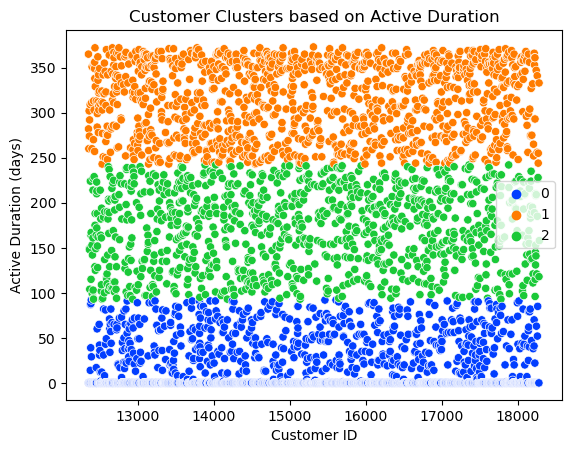

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extracting the 'Active Duration' column and converting it to total days
duration['Active_Duration_Days'] = duration['Active duration'].apply(lambda x: pd.Timedelta(x).days)

# Selecting relevant features for clustering
X = duration[['Active_Duration_Days']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 3  # You can adjust this based on the elbow method plot

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
duration['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
sns.scatterplot(x='CustomerID', y='Active_Duration_Days', hue='Cluster', data=duration, palette='bright')
plt.title('Customer Clusters based on Active Duration')
plt.xlabel('Customer ID')
plt.ylabel('Active Duration (days)')
plt.legend()
plt.show()


These clients are divided into three groups: 
* Cluster 0:- New clients, who began purchasing things only a few days ago.
* Cluster 1:- Prospective Customers, They are continually purchasing items and have the potential to become loyal customers.
* Cluster 2:- Loyal Customers, who buy items from the business on a regular basis and stay for a long time.

## <center> RETURN AND REFUNDS

The data has some items which are cancelled. For our purposes, I'll refer to it as Returns or Refunds. This is due to the goods' negative quantities and stock prices. Customers must have already purchased it.

In [62]:
total_orders = len(df)
canceled_orders = len(cancelled_items)

print("Numbers of cancelled orders : ",canceled_orders)

Numbers of cancelled orders :  8905


In [63]:
# Calculate the percentage of the cancelled orders with respective to the total number of orders

percentage_canceled = (canceled_orders / total_orders) * 100

print(f"The percentage of orders with returns or refunds is: {percentage_canceled:.2f}%")


The percentage of orders with returns or refunds is: 2.27%


The analysis reveals that around 2.27% of the total orders in the dataset are associated with returns or refunds, signifying a relatively moderate proportion of cancellations. This percentage serves as a valuable metric for gauging the extent of order cancellations and their impact on the overall order fulfillment process. While the figure is relatively low, it underscores the importance of monitoring cancellations to identify patterns, improve customer satisfaction, and refine operational strategies. Businesses can leverage this insight to implement targeted measures aimed at minimizing cancellations, optimizing inventory management, and enhancing customer experience, ultimately contributing to more efficient and customer-centric business practices

In [64]:
stockcode_counts = df.groupby(['StockCode', 'Description']).size().reset_index(name='Total')

# Filter rows in 'cancelled_items' where Quantity is negative (indicating cancelled items)
cancelled_stockcode_counts = cancelled_items.loc[cancelled_items['Quantity'] < 0,
                                                 ['StockCode', 'Description']].value_counts().reset_index(name='Cancelled')

# Merge the counts and fill NaN values with 0 (for stocks that were not cancelled)
merged_counts = pd.merge(stockcode_counts, cancelled_stockcode_counts,
                         on=['StockCode', 'Description'], how='left').fillna(0)

# Calculate the percentage of stocks cancelled
merged_counts['CancellationPercentage'] = (merged_counts['Cancelled'] / merged_counts['Total']) * 100

# Filter rows where both 'Total' and 'Cancelled' are not equal to zero
filtered_counts = merged_counts[(merged_counts['Total'] != 0) & (merged_counts['Cancelled'] != 0) 
                                & (merged_counts['CancellationPercentage'] <= 100)
                               & (merged_counts['CancellationPercentage'] > 0)]

# Print or use the result
filtered_counts = filtered_counts.sort_values('CancellationPercentage', ascending=False)

filtered_counts


StockCode                          Description  Total  Cancelled  \
3165     85047  WHITE BEADED GARLAND STRING 20LIGHT      2        2.0   
3541    90177A        CLASSIC DIAMANTE EARRINGS JET      1        1.0   
3545    90177E         DROP DIAMANTE EARRINGS GREEN      1        1.0   
3529     90169                      DAISY HAIR COMB      1        1.0   
2385     23630   SET 10 CARDS HANGING BAUBLES 17080      1        1.0   
...        ...                                  ...    ...        ...   
2893    84596B   SMALL DOLLY MIX DESIGN ORANGE BOWL    368        1.0   
1470     22620          4 TRADITIONAL SPINNING TOPS    370        1.0   
338      21080  SET/20 RED RETROSPOT PAPER NAPKINS     746        2.0   
929      22029               SPACEBOY BIRTHDAY CARD    395        1.0   
421      21213          PACK OF 72 SKULL CAKE CASES    504        1.0   

      CancellationPercentage  
3165              100.000000  
3541              100.000000  
3545              100.000000  
3529              100.000000  
2385              100.000000  
...                      ...  
2893                0.271739  
1470                0.270270  
338                 0.268097  
929                 0.253165  
421                 0.198413  

[1840 rows x 5 columns]

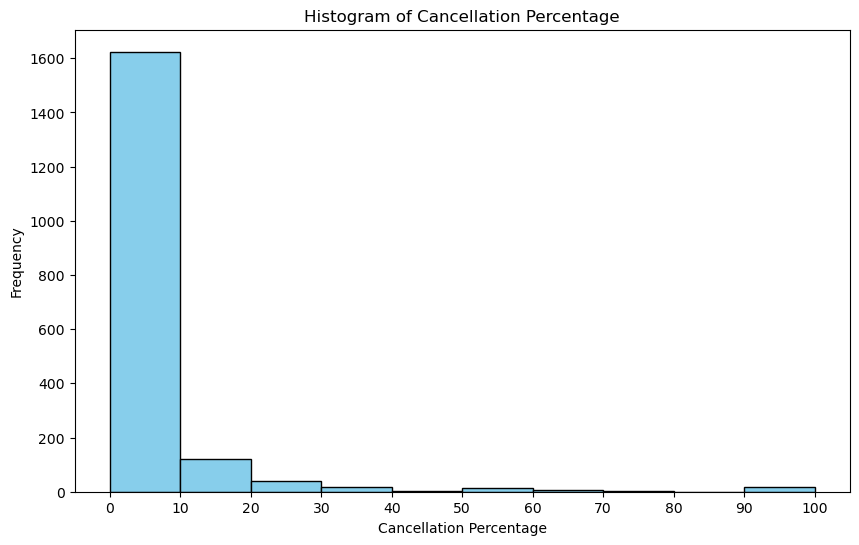

In [65]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_counts['CancellationPercentage'], bins=range(0, 110, 10), color='skyblue', edgecolor='black')
plt.xlabel('Cancellation Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Cancellation Percentage')
plt.xticks(range(0, 110, 10))
plt.show()


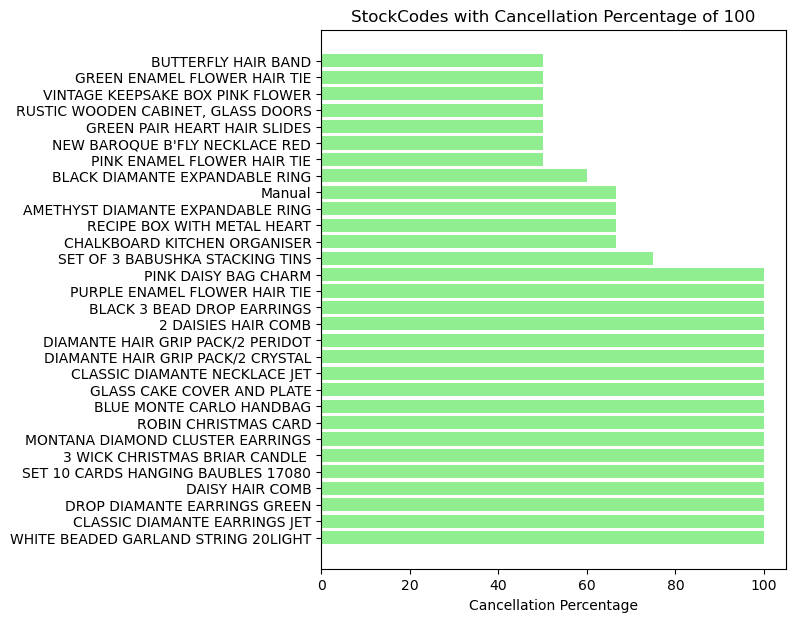

In [66]:
import matplotlib.pyplot as plt


# Filter rows where Cancellation Percentage is 100
filtered_percentage = filtered_counts.head(30)

# Plotting
plt.figure(figsize=(6, 7))
plt.barh(filtered_percentage['Description'],
         filtered_percentage['CancellationPercentage'], color='lightgreen')
plt.xlabel('Cancellation Percentage')
plt.title('StockCodes with Cancellation Percentage of 100')
plt.show()


The analysis of cancellation percentages reveals notable insights into the performance of specific items. Some products, such as 'WHITE BEADED GARLAND STRING 20LIGHT' and 'CLASSIC DIAMANTE EARRINGS JET,' consistently experience 100% cancellation rates, indicating potential issues. Conversely, the majority of items exhibit lower cancellation percentages, suggesting stable demand. This information is vital for inventory management and marketing, guiding businesses to address concerns with specific items and optimize stocking strategies for improved operational efficiency and customer satisfaction.

## <CENTER> PROFIT ANALYSIS

In [67]:
#Total profit generated by the company

# Calculate the revenue and profit for each row
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Profit'] = df['Revenue'] - df['UnitPrice']

# Calculate the total profit
total_profit_generated = df['Profit'].sum()

print('Total profit generated is:', round(total_profit_generated))

Total profit generated is: 6806926


In [68]:
#Top 5 products with the highest profit margin
import pandas as pd

# Calculate the revenue and profit for each row
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Profit'] = df['Revenue'] - df['UnitPrice']

# Calculate profit margin (Profit / Revenue)
df['ProfitMargin'] = df['Profit'] *100 / df['Revenue'] 

product_profit_margin = df.groupby('Description')['ProfitMargin'].mean().reset_index()

sorted_prod = product_profit_margin.sort_values(by='ProfitMargin', ascending=False)

top_five_products = sorted_prod.head(5)

top_five_products

Description  ProfitMargin
1324  GIRLS ALPHABET IRON ON PATCHES      99.670894
514     BOYS ALPHABET IRON ON PATCHES     99.513889
1921            MINI HIGHLIGHTER PENS     99.322917
2453       POPART WOODEN PENCILS ASST     99.065056
220             ASSORTED INCENSE PACK     98.882888

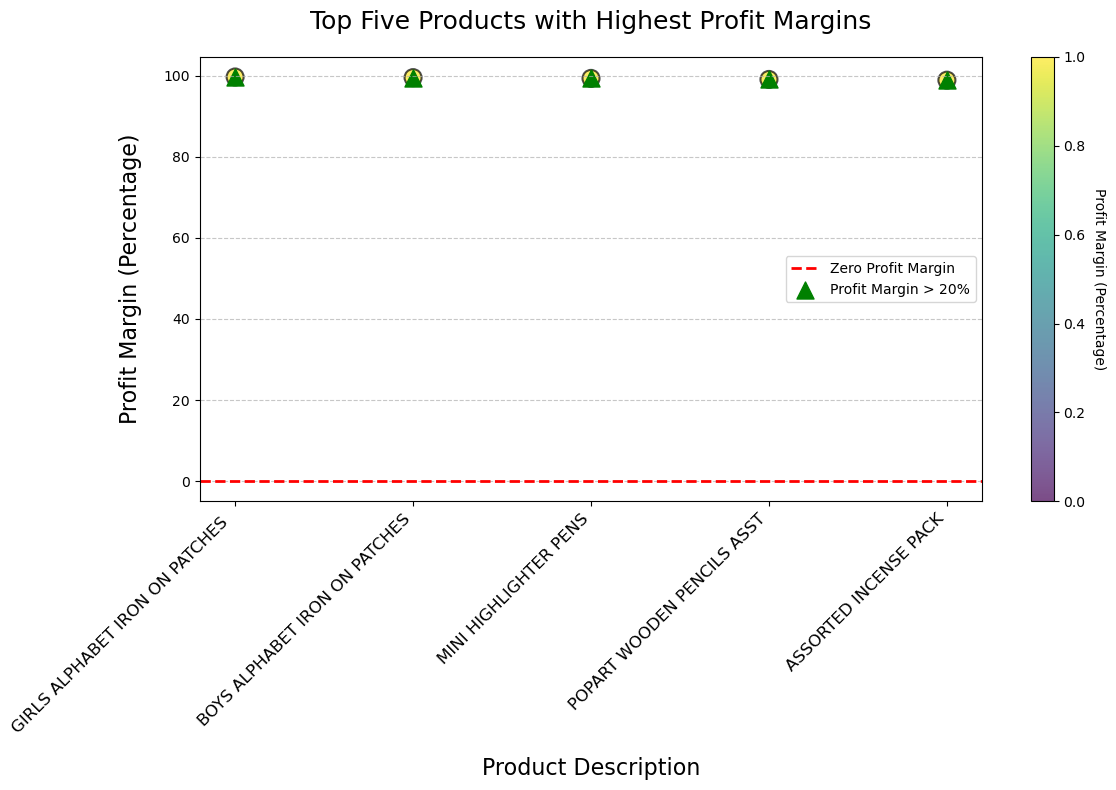

In [69]:
import matplotlib.pyplot as plt

# Create a color map for better visualization
colors = plt.cm.viridis(top_five_products['ProfitMargin'] / 100)  

# Plotting the scatter plot with enhanced aesthetics
plt.figure(figsize=(12, 8))
scatter = plt.scatter(top_five_products['Description'], top_five_products['ProfitMargin'],
                      c=colors, s=150, alpha=0.7, edgecolors='black', linewidths=1.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Profit Margin (Percentage)', rotation=270, labelpad=15)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Product Description', fontsize=16, labelpad=15)
plt.ylabel('Profit Margin (Percentage)', fontsize=16, labelpad=15)
plt.title('Top Five Products with Highest Profit Margins', fontsize=18, pad=20)

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Profit Margin')

threshold = 20 
above_threshold = top_five_products[top_five_products['ProfitMargin'] > threshold]
plt.scatter(above_threshold['Description'], above_threshold['ProfitMargin'],
            color='green', s=150, marker='^', label=f'Profit Margin > {threshold}%')

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


For each product in a DataFrame, the supplied code performs an extensive analysis of revenue, profit, and profit margins. The code determines the top five products with the highest average profit margins by calculating each product's average profit margin and sorting the results in descending order. The profit margins of the top five products are displayed in a scatter plot created by the provided code, which also provides a visual depiction of the individual product contributions and the associated profit percentages. The products are shown on the horizontal axis, and the percentage profit margins are shown on the vertical axis. A clear picture of the distribution and fluctuation of profit margins among the best-performing products can be obtained from the scatter plot.

##  <center> CUSTOMER SATISFACTION

Apparently there is no data available on customer feedback or ratings for products or services.

Hence we are adding a new column named CustomerFeedback into the dataframe and assigning random feedback values in the scale of 1 to 5 to carryout the analysis

In [70]:
df_cus_satisfaction=df.copy()
df_cus_satisfaction['CustomerFeedback'] = np.random.randint(1, 6, size=len(df_cus_satisfaction))
df_cus_satisfaction
probabilities = [0.1, 0.2, 0.3, 0.2, 0.2]

# Add a new column 'CustomerFeedback' with random ratings based on probabilities
df_cus_satisfaction['CustomerFeedback'] = np.random.choice(np.arange(1, 6), size=len(df_cus_satisfaction), p=probabilities)
df_cus_satisfaction.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
5 2010-12-01 08:26:00       7.65       17850  United Kingdom       15.30   
6 2010-12-01 08:26:00       4.25       17850  United Kingdom       25.50   
7 2010-12-01 08:28:00       1.85       17850  United Kingdom       11.10   
8 2010-12-01 08:28:00       1.85       17850  United Kingdom       11.10   
9 2010-12-01 08:34:00       1.69       13047  United Kingdom       54.08   

   Revenue PaymentMethod  Profit  ProfitMargin  CustomerFeedback  
0    15.30    CreditCard   12.75     83.333333                 2  
1    20.34           EMI   16.95     83.333333                 2  
2    22.00           EMI   19.25     87.500000                 4  
3    20.34          cash   16.95     83.333333                 3  
4    20.34    CreditCard   16.95     83.333333                 4  
5    15.30    CreditCard    7.65     50.000000                 3  
6    25.50    CreditCard   21.25     83.333333                 3  
7    11.10           EMI    9.25     83.333333                 4  
8    11.10          cash    9.25     83.333333                 2  
9    54.08           EMI   52.39     96.875000                 2

In [71]:
sentiment_counts = df_cus_satisfaction['CustomerFeedback'].value_counts().sort_index()

# Display the counts
print("Sentiment Counts:")
for rating, count in sentiment_counts.items():
    print(f"Rating {rating}: {count} customers")

Sentiment Counts:
Rating 1: 39225 customers
Rating 2: 78584 customers
Rating 3: 117404 customers
Rating 4: 78238 customers
Rating 5: 78658 customers


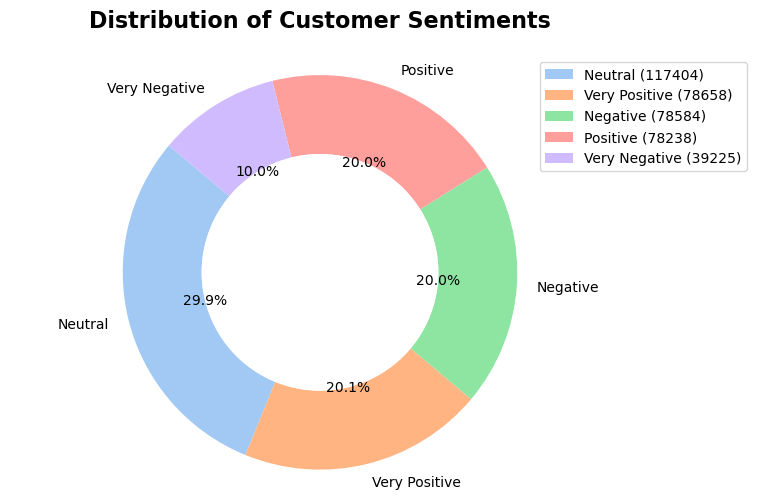

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Define a function to categorize ratings into sentiment levels
def categorize_sentiment(rating):
    if rating == 5:
        return 'Very Positive'
    elif rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    elif rating >= 2:
        return 'Negative'
    else:
        return 'Very Negative'

df_cus_satisfaction['Sentiment'] = df_cus_satisfaction['CustomerFeedback'].apply(categorize_sentiment)

sentiment_counts = df_cus_satisfaction['Sentiment'].value_counts()

colors = sns.color_palette("pastel")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.4))

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Customer Sentiments', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

legend_labels = [f'{label} ({count})' for label, count in zip(sentiment_counts.index, sentiment_counts)]
plt.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Add a shadow effect to the pie chart
ax.set_box_aspect(0.7)
ax.set_aspect('equal')
ax.set_facecolor('lightgray')
ax.set_zorder(1)
ax.set_frame_on(False)

# Show the plot
plt.show()


Customers are generally satisfied with the product or service. The fact that the majority of customer sentiments are positive suggests that customers are generally satisfied with the product or service.
There is room for improvement. The fact that 20% of customer sentiments are neutral or negative suggests that there is room for improvement in customer satisfaction.

The business should focus on retaining and marketing to its most satisfied customers. The fact that the majority of customer sentiments are positive suggests that the business should focus on retaining and marketing to its most satisfied customers.

The business should investigate the root causes of customer dissatisfaction. The fact that 20% of customer sentiments are neutral or negative suggests that the business should investigate the root causes of customer dissatisfaction and take steps to address them.
